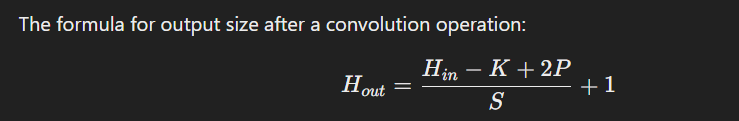

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
df = pd.read_csv(r"/content/fashion-mnist_train.csv")

In [4]:
df = df.fillna(0)

In [5]:
x=df.drop("label",axis=1)
y=df["label"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
X_train = X_train/255.0
X_test = X_test/255.0

In [8]:
X_train = torch.from_numpy(X_train.values).float()
X_test = torch.from_numpy(X_test.values).float()
y_train = torch.from_numpy(y_train.values).long()
y_test = torch.from_numpy(y_test.values).long()

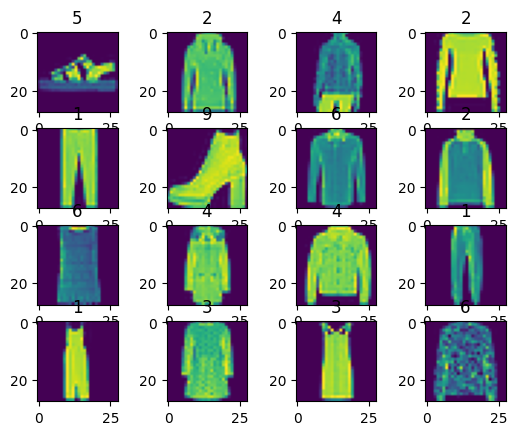

In [9]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.title(y_train[i].item())
  plt.imshow(X_train[i].reshape(28,28))
plt.show()

In [10]:
class custom_dataset(Dataset):
  def __init__(self,x,y):
    self.x=x.reshape(-1,1,28,28)
    self.y=y
  def __len__(self):
    return len(self.x)
  def __getitem__(self,index):
    return self.x[index],self.y[index]

In [11]:
train_data=custom_dataset(X_train,y_train)
test_data=custom_dataset(X_test,y_test)

In [12]:
train_loader=DataLoader(train_data,batch_size=32,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_data,batch_size=32,shuffle=False,pin_memory=True)


In [23]:
class Model(nn.Module):
  def __init__(self,input_channel):
    super(Model,self).__init__()

    self.net = nn.Sequential(
        nn.Conv2d(input_channel,32,3,1,0),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,3,1,0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),
        nn.Flatten()
    )
    self.fc = nn.Sequential(
        nn.Linear(1600,128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128,128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128,10)
    )
  def forward(self,x):
    return self.fc(self.net(x))


In [24]:
model = Model(1).to(device)

In [25]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.05)

In [26]:
for i in range(50):
  net_loss=0
  for x,y in train_loader:
    x=x.to(device)
    y=y.to(device)
    y_pred = model(x)
    l = loss(y_pred,y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    net_loss+=l.item()

  print(f"Epoch {i} Loss {net_loss/32}")

Epoch 0 Loss 13.654278973350301
Epoch 1 Loss 9.073409746401012
Epoch 2 Loss 7.558390558813699
Epoch 3 Loss 6.911056717392057
Epoch 4 Loss 6.119104179611895
Epoch 5 Loss 5.5529002661351115
Epoch 6 Loss 5.065660470514558
Epoch 7 Loss 4.7158871275314596
Epoch 8 Loss 4.164229490925209
Epoch 9 Loss 3.8573281158830923
Epoch 10 Loss 3.7120563910484634
Epoch 11 Loss 3.3121935555973323
Epoch 12 Loss 3.137874854609933
Epoch 13 Loss 2.7679131254189997
Epoch 14 Loss 2.666562017200178
Epoch 15 Loss 2.2727489035914914
Epoch 16 Loss 2.2371888400945554
Epoch 17 Loss 1.9785263888170448
Epoch 18 Loss 2.1319682762514276
Epoch 19 Loss 1.7924498280008265
Epoch 20 Loss 1.623408400828339
Epoch 21 Loss 1.6413758590438192
Epoch 22 Loss 1.491004729542965
Epoch 23 Loss 1.3237810732734943
Epoch 24 Loss 1.4058760012421772
Epoch 25 Loss 1.2220557972476627
Epoch 26 Loss 1.2105374561288045
Epoch 27 Loss 1.081150481985181
Epoch 28 Loss 1.0084352008977169
Epoch 29 Loss 1.0228560929097057
Epoch 30 Loss 0.951404995551115

In [27]:
model.eval()

Model(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=1600, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [33]:
correct=0
total=0
with torch.no_grad():
  for x,y in test_loader:

    x=x.to(device)
    y=y.to(device)
    y_pred = model(x)
    correct+=torch.sum(torch.argmax(y_pred,dim=1)==y).item()
    total+=y.shape[0]
print(f"Accuracy {correct*100/total}%")

Accuracy 90.30479399601776%


In [32]:
correct=0
total=0
with torch.no_grad():
  for x,y in train_loader:

    x=x.to(device)
    y=y.to(device)
    y_pred = model(x)
    correct+=torch.sum(torch.argmax(y_pred,dim=1)==y).item()
    total+=y.shape[0]
print(f"Accuracy {correct*100/total}*%")

Accuracy 99.65919969366264*%
